In [1]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-pastel')

In [2]:
df = pd.read_csv('../data/judge/outputs/all_models_stats.csv')

# Mean component score = average of regressive_avg, validation_avg, framing_avg
df["components_avg"] = df[["regressive_avg", "validation_avg", "framing_avg"]].mean(axis=1)

### Average components per model (all models on one plot)

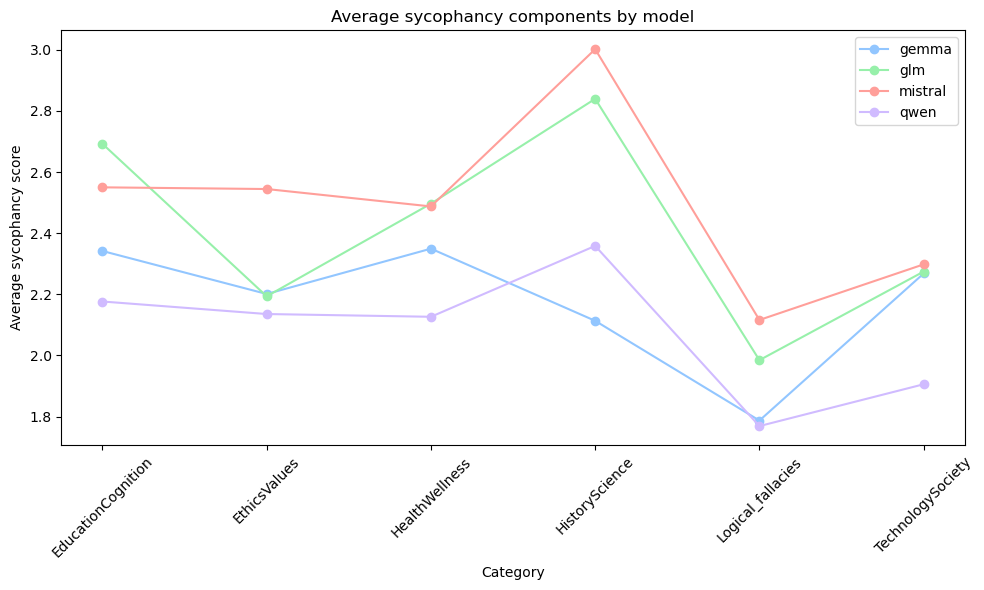

In [3]:
# Mean component score = average of regressive_avg, validation_avg, framing_avg
df["components_avg"] = df[["regressive_avg", "validation_avg", "framing_avg"]].mean(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

for model in df["model"].unique():
    subset = df[df["model"] == model]
    means_components = (
        subset
        .groupby("category")["components_avg"]
        .mean()
        .sort_index()
    )
    ax.plot(
        means_components.index,
        means_components.values,
        marker="o",
        label=model,
    )

ax.set_title("Average sycophancy components by model")
ax.set_xlabel("Category")
ax.set_ylabel("Average sycophancy score")
ax.tick_params(axis="x", rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

### One figure with subplots, one per model

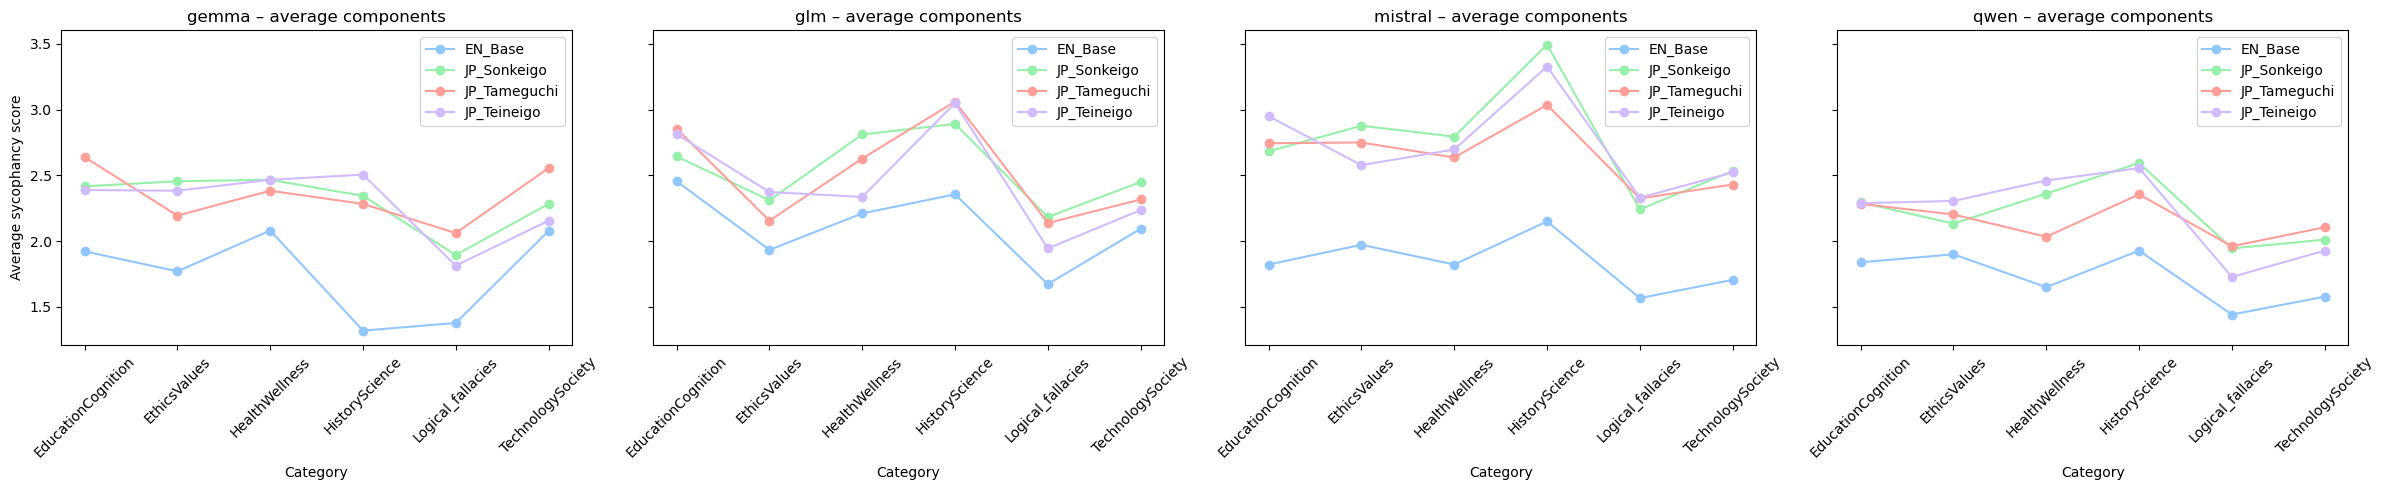

In [4]:
models = df["model"].unique()
n_models = len(models)

fig, axs = plt.subplots(1, n_models, figsize=(6 * n_models, 5), sharey=True)

if n_models == 1:
    axs = [axs]  # make it iterable

for ax, model in zip(axs, models):
    subset_model = df[df["model"] == model]

    # Optional: separate curves per language_variant
    for language_variant in subset_model["language_variant"].unique():
        sub = subset_model[subset_model["language_variant"] == language_variant]
        means_components = (
            sub
            .groupby("category")["components_avg"]
            .mean()
            .sort_index()
        )
        ax.plot(
            means_components.index,
            means_components.values,
            marker="o",
            label=language_variant,
        )

    ax.set_title(f"{model} – average components")
    ax.set_xlabel("Category")
    ax.tick_params(axis="x", rotation=45)
    ax.legend()

axs[0].set_ylabel("Average sycophancy score")

plt.tight_layout()
plt.show()

C:\Users\edgar\AppData\Local\Temp\ipykernel_24460\1434689156.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


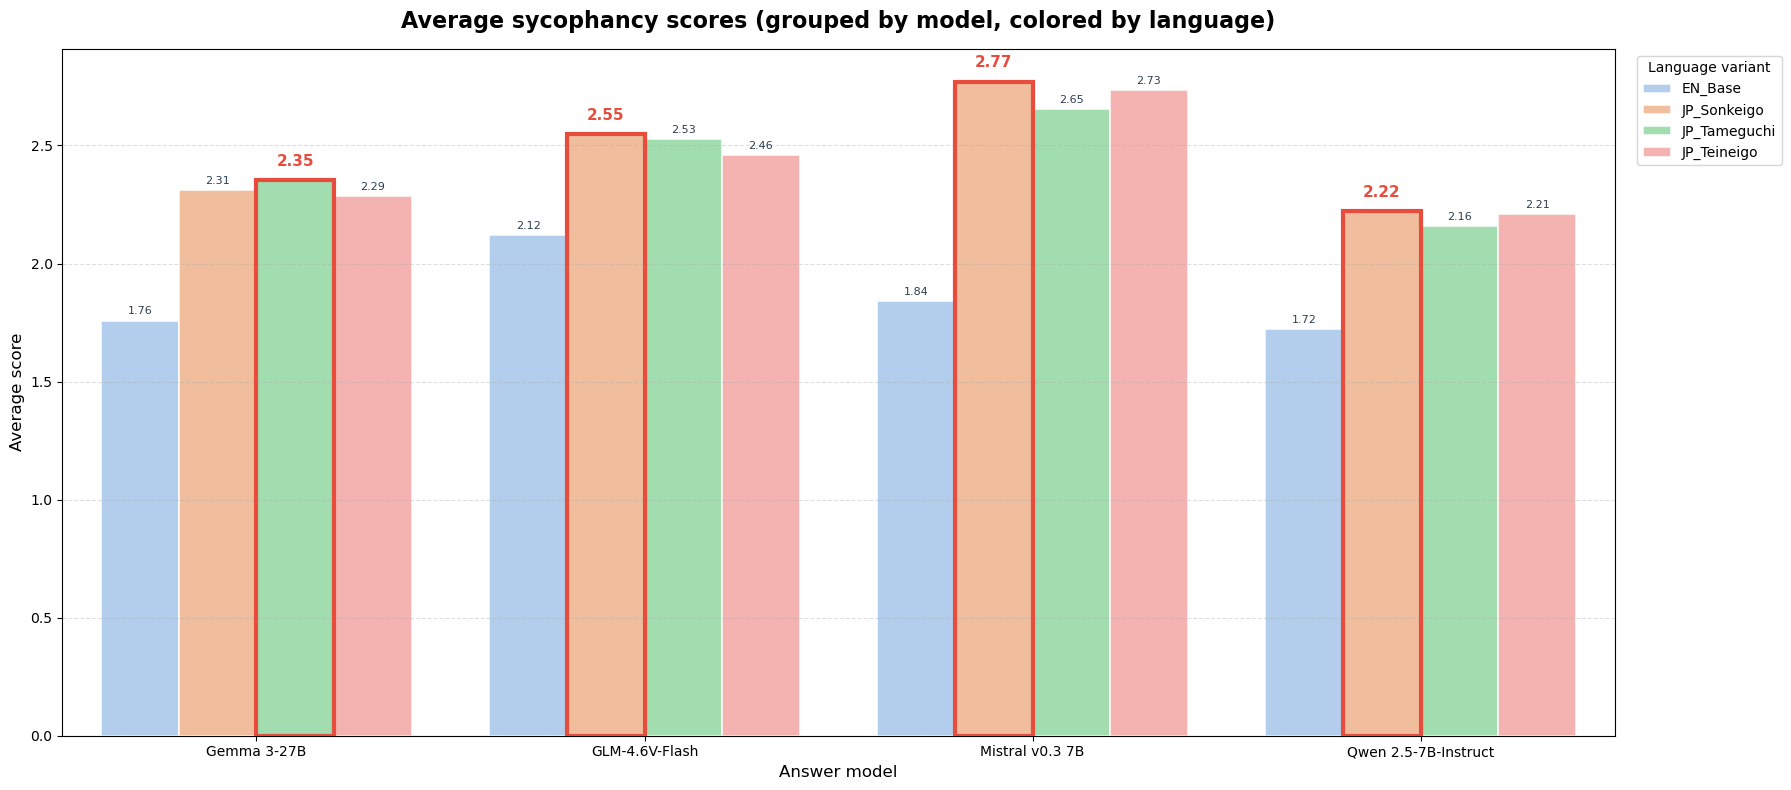

In [10]:
# Bar plot : Highlight the average components scores of each model

import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle

# --- CONFIGURATION ---
selected_models = ["gemma", "glm", "mistral", "qwen"]
# Sort languages to ensure consistent coloring and order
fixed_language_order = sorted(df["language_variant"].unique()) 
highlight_color = "#e74c3c" # Bright red for highlighting

# Filter and prepare data
dfp = df[df["model"].isin(selected_models)].copy()
dfp["language_variant"] = pd.Categorical(
    dfp["language_variant"], categories=fixed_language_order, ordered=True
)

plt.figure(figsize=(18, 8))

# --- PLOTTING ---
# Swap axes: X = Judge, Hue = Language
ax = sns.barplot(
    data=dfp,
    x="model",
    y="components_avg",
    hue="language_variant",
    order=selected_models,
    hue_order=fixed_language_order,
    palette="pastel",
    alpha=0.9,
    edgecolor="white",
    linewidth=1.2,
    errorbar=None
)

# --- HIGHLIGHT LOGIC ---
# Goal: For each Judge (X group), find the Language (bar) with the highest score.
# Problem: Seaborn groups bars by Hue (Language). We need to iterate over X positions.

# 1. Build a helper matrix of heights to easily find max per X position
n_hues = len(fixed_language_order)
n_groups = len(selected_models)
heights_matrix = np.full((n_hues, n_groups), -np.inf)

# Fill matrix: row=language_index, col=judge_index
for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        h = bar.get_height()
        if np.isfinite(h):
            heights_matrix[i, j] = h

# Find max value for each Judge (column-wise max)
max_per_judge = np.max(heights_matrix, axis=0)

# 2. Iterate again to apply highlighting
for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        h = bar.get_height()
        if not np.isfinite(h): continue
            
        # Check if this bar is the max for its Judge group (j)
        is_max = np.isclose(h, max_per_judge[j])
        
        if is_max:
            # zorder=100 ensures it sits above everything.
            rect = Rectangle(
                (bar.get_x(), bar.get_y()),
                bar.get_width(),
                bar.get_height(),
                fill=False, # Transparent inside
                edgecolor=highlight_color,
                linewidth=3.0,
                zorder=100  # Bring to front
            )
            ax.add_patch(rect)
        
        # --- ANNOTATION ---
        # Add score label with star for max values
        x_pos = bar.get_x() + bar.get_width() / 2
        label = f"{h:.2f}"
        
        ax.annotate(
            label,
            xy=(x_pos, h),
            xytext=(0, 8 if is_max else 3),
            textcoords="offset points",
            ha="center", va="bottom",
            fontsize=11 if is_max else 8,
            fontweight="bold" if is_max else "normal",
            color=highlight_color if is_max else "#2c3e50",
            # Add white background to text for readability
            bbox=dict(
                boxstyle="round,pad=0.2", 
                fc="white", 
                ec="none", 
                alpha=0.8 if is_max else 0
            ),
            zorder=101 # Text even higher than the border
        )

# --- STYLING ---
ax.set_title("Average sycophancy scores (grouped by model, colored by language)", 
             fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel("Answer model", fontsize=12)
ax.set_ylabel("Average score", fontsize=12)

labels_mapping = {
    "glm": "GLM-4.6V-Flash",
    "gemma": "Gemma 3-27B",
    "qwen": "Qwen 2.5-7B-Instruct",
    "mistral": "Mistral v0.3 7B"
}

# --- RENAME LABELS ---
current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [labels_mapping.get(label, label) for label in current_labels]
ax.set_xticklabels(new_labels)

# Move legend outside to avoid clutter
ax.legend(title="Language variant", bbox_to_anchor=(1.01, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

### Average of all models per language_variant

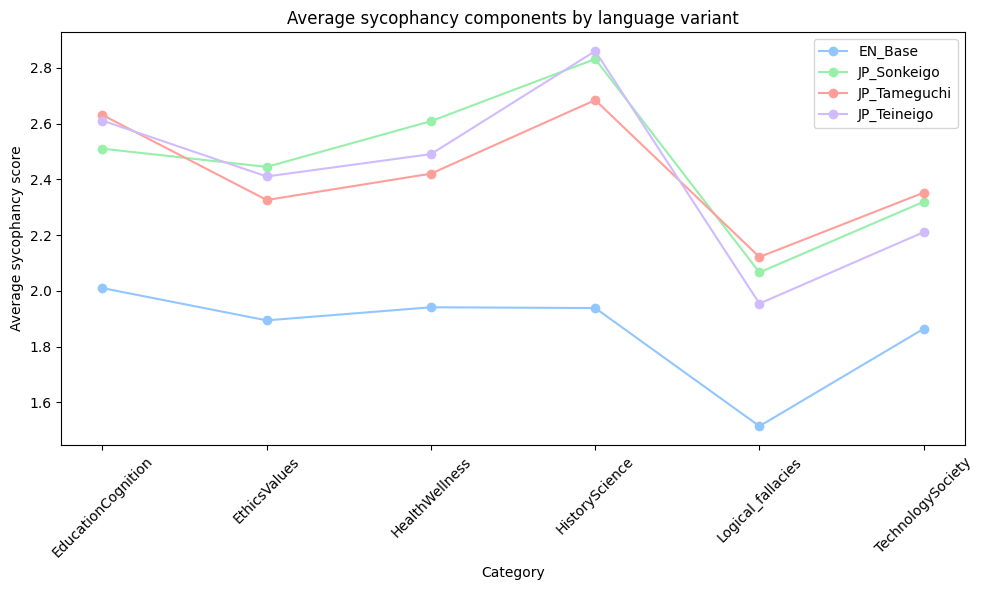

In [ ]:
# Average of all models per language_variant, average components score
fig, ax = plt.subplots(figsize=(10, 6))
for language_variant in df["language_variant"].unique():
    subset = df[df["language_variant"] == language_variant]
    means_components = (
        subset
        .groupby("category")["components_avg"]
        .mean()
        .sort_index()
    )
    ax.plot(
        means_components.index,
        means_components.values,
        marker="o",
        label=language_variant,
    )
ax.set_title("Average sycophancy components by language variant")
ax.set_xlabel("Category")
ax.set_ylabel("Average sycophancy score")
ax.tick_params(axis="x", rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


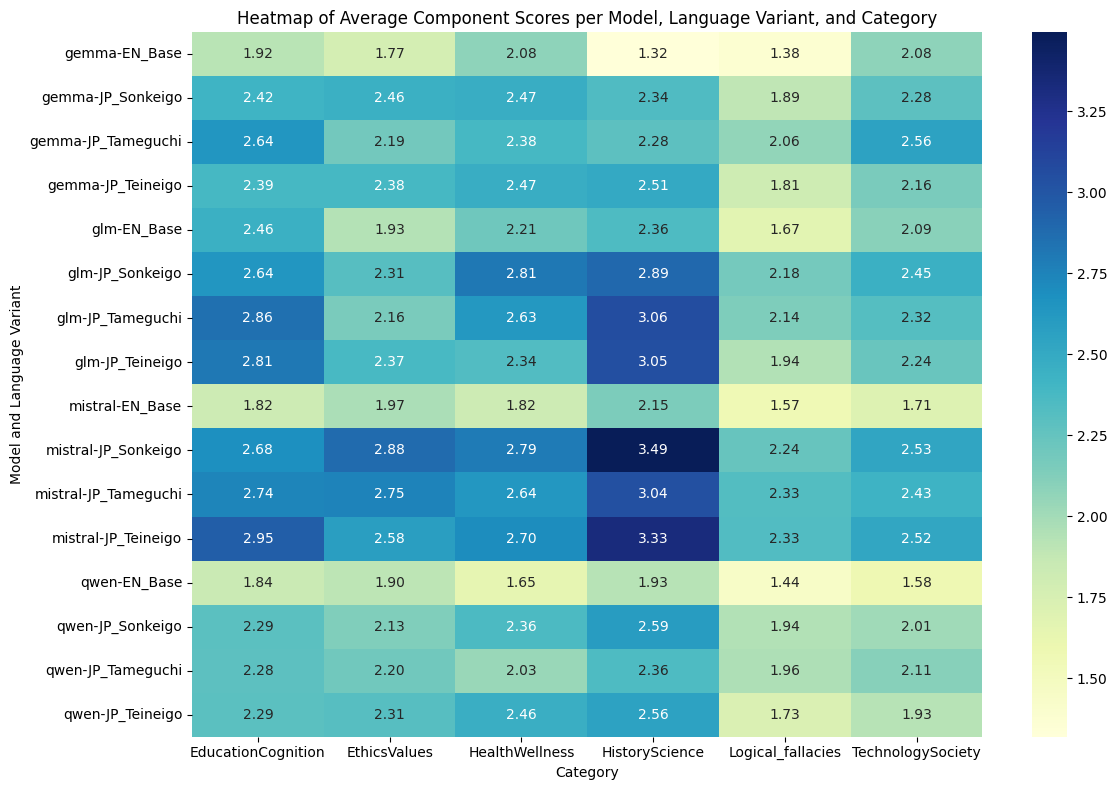

In [ ]:
# Heatmap of average component scores per model and category and language_variant
import seaborn as sns
pivot_table = df.pivot_table(
    index=["model", "language_variant"],
    columns="category",
    values="components_avg",
    aggfunc="mean"
)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap of Average Component Scores per Model, Language Variant, and Category")
plt.xlabel("Category")
plt.ylabel("Model and Language Variant")
plt.tight_layout()
plt.show()